## Imports principais

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import osmnx as ox

## Definições de funções
### Aqui serão definidas as funções utilizadas no restante do código, facilitando a leitura do código nos enunciados.


In [15]:
def betweenessCentrality(graph):
    x = dict(nx.betweenness_centrality(graph))
    x = pd.Series(x)
    return x

def closenessCentrality(graph):
    x = dict(nx.closeness_centrality(graph))
    x = pd.Series(x)
    return x

#TODO, metodo existe na documentação, mas não existe na implementação.
def communicabilityCentrality(graph):
    x = dict(nx.communicability_centrality(graph))
    x = pd.Series(x)
    return x

def degrees(graph):
    x = dict(nx.degree(graph))
    x = pd.Series(x)
    return x

def eigenVectorCentrality(graph,max_iter=100):
    x = dict(nx.eigenvector_centrality(graph, max_iter=max_iter))
    x = pd.Series(x)
    return x

def kCore(graph):
    x = dict(nx.core_number(graph))
    x = pd.Series(x)
    return x

def pageRank(graph, alpha=0.85):
    x = dict(nx.pagerank(graph, alpha=alpha))
    x = pd.Series(x)
    return x

def plotCorr(corr):
    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(19, 15))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
    plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    plt.show()

#Fonte: Material de aula
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

#Similar ao da lista 1, mas saída está em pd.Series    
def random_walk(g, steps=100):
    g_mat = nx.to_numpy_array(g, nodelist=sorted(g.nodes()))    
    path = np.zeros((steps,), dtype=np.int64)
    step = 0
    for i in range(steps-1):
        path[i] = step
        step = np.random.choice(np.arange(g_mat.shape[1])[g_mat[step, :] > 0.0])
    path[i+1] = step
    return pd.Series(path)


        

## Leitura dos grafos principais (apenas o maior componente conexo é mantido).

In [6]:
# Airport
airport = nx.read_edgelist("datasets/USairport_2010.txt", nodetype=int, data=(('weight',float),))
airport = max(nx.connected_component_subgraphs(airport), key=len)
airport = airport.to_undirected()
airport = nx.convert_node_labels_to_integers(airport, first_label=0)
print("\n\nUSA Airport")
printInfo(airport)

# c-elegans neural
celegans = nx.read_edgelist('datasets/C-elegans-frontal.txt')
celegans = max(nx.connected_component_subgraphs(celegans), key=len)
celegans = celegans.to_undirected()
celegans = nx.convert_node_labels_to_integers(celegans, first_label=0)
print("\n\nC-Elegans")
print("Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html\nA versao em .gml estava dando erro.")
printInfo(celegans)

# c-elegans 2004
celegans2004 = nx.read_edgelist('datasets/C-elegans-2004.txt')
celegans2004 = max(nx.connected_component_subgraphs(celegans2004), key=len)
celegans2004 = celegans2004.to_undirected()
celegans2004 = nx.convert_node_labels_to_integers(celegans2004, first_label=0)
print("\n\nC-Elegans 2004")
printInfo(celegans2004)

# c-elegans 2007
celegans2007 = nx.read_edgelist('datasets/C-elegans-2007.txt')
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = celegans2007.to_undirected()
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#E-Roads
e_road = nx.read_edgelist('datasets/euroroad', comments='%')
e_road = max(nx.connected_component_subgraphs(e_road), key=len)
e_road = e_road.to_undirected()
e_road = nx.convert_node_labels_to_integers(e_road, first_label=0)
print("E-Roads")
printInfo(e_road)

# Hamsterster Friends
ham = nx.read_edgelist('datasets/hamsterster', comments='%')
ham = max(nx.connected_component_subgraphs(ham), key=len)
ham = ham.to_undirected()
ham = nx.convert_node_labels_to_integers(ham, first_label=0)
print("\n\nHamsterster Friends")
printInfo(ham)

#Human Protein
protein = nx.read_edgelist("datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

#Karate Club
karate = nx.karate_club_graph()
karate = max(nx.connected_component_subgraphs(karate), key=len)
karate = karate.to_undirected()
karate = nx.convert_node_labels_to_integers(karate, first_label=0)
print("\n\nKarate Club")
printInfo(karate)

#Power Grid
power_grid = nx.read_gml('datasets/power.gml', label=None)
power_grid = max(nx.connected_component_subgraphs(power_grid), key=len)
power_grid = power_grid.to_undirected()
power_grid = nx.convert_node_labels_to_integers(power_grid, first_label=0)
print("\n\nPower Grid")
printInfo(power_grid)

#R Dependencies
r_dependencies = nx.read_edgelist('datasets/Rdependencies.csv', comments='%', delimiter=',',nodetype=str)
r_dependencies = max(nx.connected_component_subgraphs(r_dependencies), key=len)
r_dependencies = r_dependencies.to_undirected()
r_dependencies = nx.convert_node_labels_to_integers(r_dependencies, first_label=0)
print("\n\nR Dependencies")
printInfo(r_dependencies)

#4 Cidades
#Colocar leitura das 4 cidades aqui usando osmnx como plkaceholder
#clovelly = ox.graph_from_place('Clovelly, Devon, South West England, England, EX39 5TQ, United Kingdom', which_result=2)
#walsdorf = ox.graph_from_place('Walsdorf, Landkreis Bamberg, Upper Franconia, Bavaria, 96194, Germany', which_result=1)
#emilion = ox.graph_from_place('Saint-Émilion, Libourne, Gironde, New Aquitaine, Metropolitan France, 33330, France', which_result=1)
clovelly = nx.Graph()
walsdorf = nx.Graph()
emilion = nx.Graph()



USA Airport
Nós: 1572
Arestas: 17214
Grau Médio: 21.900763358778626


C-Elegans
Fonte: https://snap.stanford.edu/data/C-elegans-frontal.html
A versao em .gml estava dando erro.
Nós: 131
Arestas: 687
Grau Médio: 10.488549618320612


C-Elegans 2004
Nós: 1084
Arestas: 1639
Grau Médio: 3.0239852398523985


C-Elegans 2007
Nós: 1108
Arestas: 1554
Grau Médio: 2.8050541516245486
E-Roads
Nós: 1039
Arestas: 1305
Grau Médio: 2.512030798845043


Hamsterster Friends
Nós: 1788
Arestas: 12476
Grau Médio: 13.955257270693512


Human Protein
Nós: 2783
Arestas: 6438
Grau Médio: 4.626661875673733


Karate Club
Nós: 34
Arestas: 78
Grau Médio: 4.588235294117647


Power Grid
Nós: 4941
Arestas: 6594
Grau Médio: 2.66909532483303


R Dependencies
Nós: 2447
Arestas: 5439
Grau Médio: 4.445443400081733


# Questões
## 1)

In [7]:
corr=dict() #maps a graphname to a pandas DataFrame with the correlations
for graph in [e_road, ham, celegans, airport]:
    d = degrees(graph)
    cc = closenessCentrality(graph)
    kc= kCore(graph)
    bc = betweenessCentrality(graph)
    ec = eigenVectorCentrality(graph,1000)
    pr = pageRank(graph)
    rw = random_walk(graph,100)
    #com = communicabilityCentrality(graph)
    metrics = [("Betweeness Centrality", bc),("Closeness Centrality",cc),("Degree",d),\
               ("EigenVector Centrality",ec), ('k-Core',kc) ,("Page Rank",pr),('Random Walk', rw)]#,("Communicability Centrality",com)]
    
    #Makes correlation between the metrics and puts it into a DataFrame
    pdCorr = dict()
    for s1 in range(0,len(metrics)):
        pdCorr[metrics[s1][0]] = dict()
        for s2 in range(0,len(metrics)):
            pdCorr[metrics[s1][0]][metrics[s2][0]] = metrics[s1][1].corr(metrics[s2][1])
    #feeding dictionary
    corr[graph] = pd.DataFrame(pdCorr)

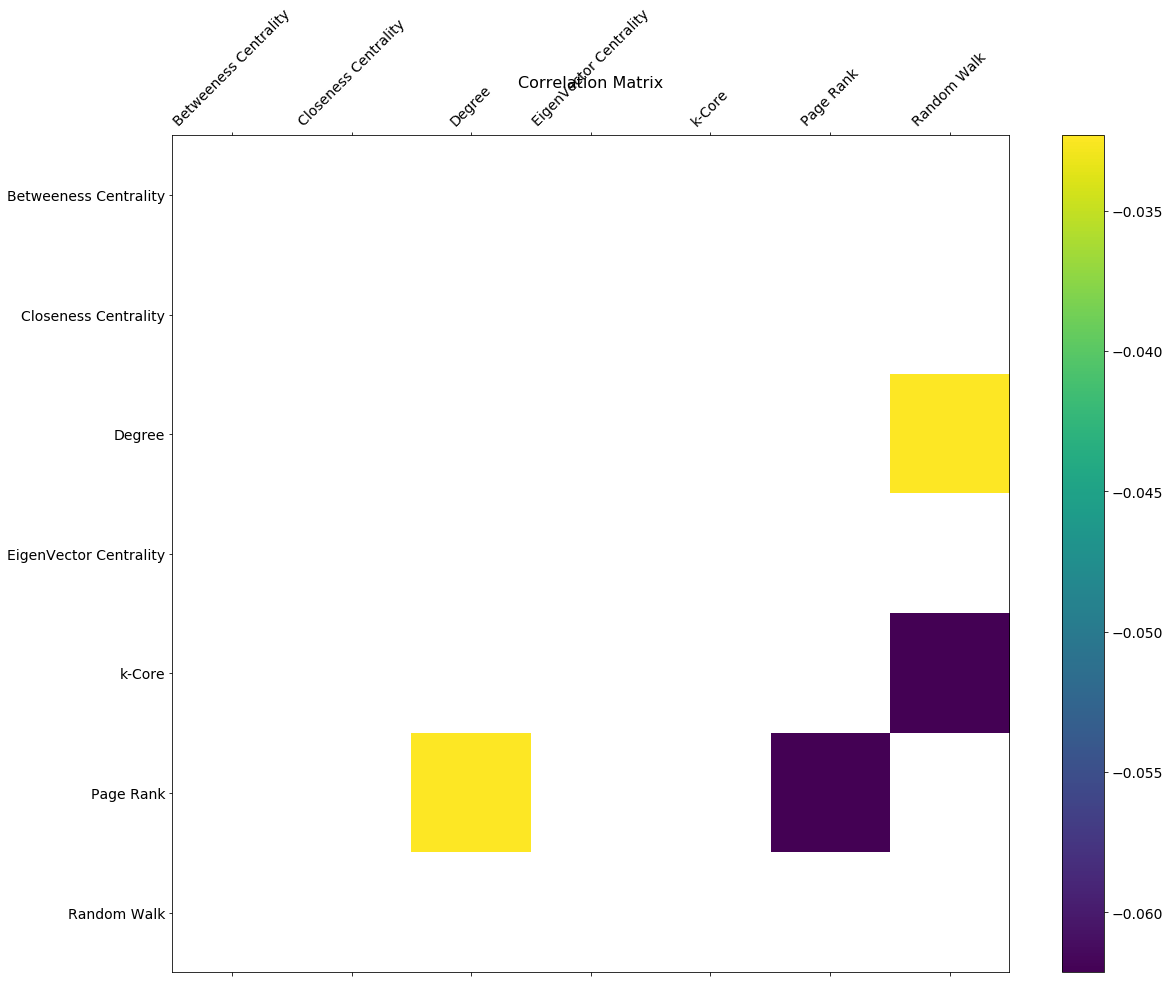

In [8]:
plotCorr(corr[e_road][corr[e_road]<0.0])
#plotCorr(corr[e_road][corr[e_road]>6.0])
#plotCorr(corr[e_road][corr[e_road]>8.0])

## Questão 2

c:\users\fsan1\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\fsan1\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

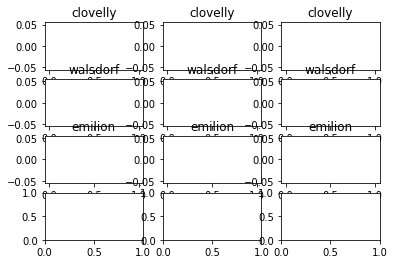

In [21]:
#Ajustar, pois as imagens estão pequenas.
fig, axis = plt.subplots(4,3)
ng = 0
metric= -1

#Colocoar mais 1
for g, title in [(clovelly,'clovelly'), (walsdorf,'walsdorf'), (emilion,'emilion')]:
    degree = degrees(g)
    closenessC = closenessCentrality(g)
    betweeness = betweenessCentrality(g)
    #Plotando
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(closenessC, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 3
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Betweeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(betweeness, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1


## Questão 3


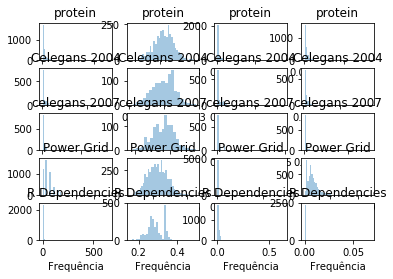

In [27]:
#Ajustar, pois as imagens estão pequenas.
fig, axis = plt.subplots(5,4)
ng = 0
metric= -1

for g, title in [(protein,'protein'), (celegans2004,'Celegans 2004'), (celegans2007,'celegans 2007'),\
                 (power_grid,'Power Grid'), (r_dependencies,'R Dependencies')]:
    
    degree = degrees(g)
    cc = closenessCentrality(g)
    ev = eigenVectorCentrality(g, max_iter = 10000) #1000 estava dando erro em um dos grafos.
    pr = pageRank(g)
    
    #Plotando
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Grau')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(degree, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Closeness Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(cc, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('EigenVector Centrality')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(ev, hist=True, kde=False, ax=axis[ng,metric]);
    
    metric = (metric + 1) % 4
    axis[ng,metric].set_title(title)
    axis[ng,metric].set_xlabel('Page Rank')
    axis[ng,metric].set_xlabel('Frequência')
    sns.distplot(pr, hist=True, kde=False, ax=axis[ng,metric]);
    ng += 1

## Questão 4